# Import Necessary Library

In [1]:
import time
from haversine_script import *
import numpy as np
import tensorflow as tf
import random
import pandas as p
import math
import matplotlib.pyplot as plt
import os
 


In [2]:

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [3]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 } ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)
tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Dataset Preprocessing Functions

In [4]:
def get_exponential_distance(x,minimum,a=60):
	positive_x= x-minimum
	numerator = np.exp(positive_x.div(a))
	denominator = np.exp(-minimum/a)
	exponential_x = numerator/denominator
	exponential_x = exponential_x * 1000  #facilitating calculations
	final_x = exponential_x
	return final_x

In [5]:
def get_powed_distance(x,minimum,b=1.1):
	positive_x= x-minimum
	numerator = positive_x.pow(b)
	denominator = (-minimum)**(b)
	powed_x = numerator/denominator
	final_x = powed_x
	return final_x

# Python Random Seeding for experiment reproducibility

In [6]:
os.environ['PYTHONHASHSEED'] = "42"
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [7]:
trial_name="MLP_withPCA=7"

In [8]:
components=7 # select the top 40 gateways 

In [9]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

# Loading Dataset

In [10]:
# reading the data
file = p.read_csv('lorawan_antwerp_2019_dataset.csv')
columns = file.columns
# x = file[columns[0:68]]
# y = file[columns[71:]]
x = file[columns[0:72]]
x = x.join(file[columns[73]])
y = file[columns[72:]]


Dataset Preprocessing

In [11]:
x = x.replace(-200,200)
minimum = x.min().min() - 1
x = x.replace(200,minimum)
print('minimum')
print(minimum)

minimum
-128.0


RSSI Data representation using Powed Function


In [12]:
final_x = get_powed_distance(x,minimum)

In [13]:
random_state = 42
x_train, x_test_val, y_train, y_test_val = train_test_split(final_x.values, y.values, test_size=0.3, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=random_state)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(91300, 73)
(19564, 73)
(19565, 73)


In [14]:


scaler = preprocessing.MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


scaler_y = preprocessing.MinMaxScaler().fit(y_train)
y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)


PCA Application

In [15]:
pca = PCA(n_components =components) 
  
x_train = pca.fit_transform(x_train) 
x_val = pca.transform(x_val)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_ 

In [16]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
n_of_features = x_train.shape[1]

(91300, 7)
(19564, 7)
(19565, 7)


# Network HyperParameters

In [17]:
dropout = 0.15
l2 = 0.00
lr = 0.0005
epochs = 10000
batch_size= 512
patience = 300

# Define the MLP Network

In [18]:
#with mirrored_strategy.scope():
model = Sequential()
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=256, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(dropout))
model.add(Dense(units=2))
model.compile(loss='mean_absolute_error',optimizer=Adam(lr=lr))

cb =[EarlyStopping(monitor='val_loss', patience=patience, verbose =1, restore_best_weights=True)]
history = model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1, callbacks= cb)


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/t

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_distributed_function_3436 in device /job:localhost/replica:0/task:0/device:GPU:0
90624/91300 [============================>.] - ETA: 0s - loss: 0.1442Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_4015 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
91300/91300 [==============================] - 18s 195us/sample - loss: 0.1437

91300/91300 [==============================] - 4s 39us/sample - loss: 0.0255 - val_loss: 0.0238
Epoch 61/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0252 - val_loss: 0.0239
Epoch 62/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0256 - val_loss: 0.0229
Epoch 63/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0253 - val_loss: 0.0246
Epoch 64/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0252 - val_loss: 0.0237
Epoch 65/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0250 - val_loss: 0.0227
Epoch 66/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0247 - val_loss: 0.0218
Epoch 67/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0246 - val_loss: 0.0236
Epoch 68/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0246 - val_loss: 0.0214
Epoch 69/10000
9

91300/91300 [==============================] - 4s 41us/sample - loss: 0.0230 - val_loss: 0.0202
Epoch 93/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0229 - val_loss: 0.0217
Epoch 94/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0229 - val_loss: 0.0207
Epoch 95/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0227 - val_loss: 0.0223
Epoch 96/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0229 - val_loss: 0.0215
Epoch 97/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0224 - val_loss: 0.0203
Epoch 98/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0225 - val_loss: 0.0225
Epoch 99/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0227 - val_loss: 0.0215
Epoch 100/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0226 - val_loss: 0.0199
Epoch 101/10000

91300/91300 [==============================] - 4s 46us/sample - loss: 0.0205 - val_loss: 0.0203
Epoch 155/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0204 - val_loss: 0.0193
Epoch 156/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0205 - val_loss: 0.0197
Epoch 157/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0206 - val_loss: 0.0182
Epoch 158/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0206 - val_loss: 0.0202
Epoch 159/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0206 - val_loss: 0.0205
Epoch 160/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0205 - val_loss: 0.0201
Epoch 161/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0208 - val_loss: 0.0189
Epoch 162/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0202 - val_loss: 0.0195
Epoch 16

Epoch 186/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0197 - val_loss: 0.0188
Epoch 187/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0197 - val_loss: 0.0190
Epoch 188/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0198 - val_loss: 0.0178
Epoch 189/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0198 - val_loss: 0.0187
Epoch 190/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0197 - val_loss: 0.0188
Epoch 191/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0196 - val_loss: 0.0192
Epoch 192/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0196 - val_loss: 0.0204
Epoch 193/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0196 - val_loss: 0.0190
Epoch 194/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0196 - val_loss:

91300/91300 [==============================] - 4s 45us/sample - loss: 0.0187 - val_loss: 0.0177
Epoch 249/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0178
Epoch 250/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0186 - val_loss: 0.0184
Epoch 251/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0185
Epoch 252/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0179
Epoch 253/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0185 - val_loss: 0.0191
Epoch 254/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0186 - val_loss: 0.0175
Epoch 255/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0199
Epoch 256/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0185 - val_loss: 0.0176
Epoch 25

91300/91300 [==============================] - 4s 44us/sample - loss: 0.0182 - val_loss: 0.0175
Epoch 280/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0182 - val_loss: 0.0176
Epoch 281/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0183 - val_loss: 0.0175
Epoch 282/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0180 - val_loss: 0.0193
Epoch 283/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0182 - val_loss: 0.0176
Epoch 284/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0181 - val_loss: 0.0178
Epoch 285/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0182 - val_loss: 0.0183
Epoch 286/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0181 - val_loss: 0.0175
Epoch 287/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0181 - val_loss: 0.0182
Epoch 28

Epoch 311/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0178 - val_loss: 0.0185
Epoch 312/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0177 - val_loss: 0.0180
Epoch 313/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0177 - val_loss: 0.0184
Epoch 314/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0178 - val_loss: 0.0178
Epoch 315/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0177 - val_loss: 0.0185
Epoch 316/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0179 - val_loss: 0.0172
Epoch 317/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0179 - val_loss: 0.0174
Epoch 318/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0178 - val_loss: 0.0169
Epoch 319/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0178 - val_loss:

91300/91300 [==============================] - 4s 46us/sample - loss: 0.0172 - val_loss: 0.0171
Epoch 374/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0172 - val_loss: 0.0179
Epoch 375/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0173 - val_loss: 0.0172
Epoch 376/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0171 - val_loss: 0.0169
Epoch 377/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0172 - val_loss: 0.0167
Epoch 378/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0172 - val_loss: 0.0173
Epoch 379/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0173 - val_loss: 0.0173
Epoch 380/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0173 - val_loss: 0.0169
Epoch 381/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0173 - val_loss: 0.0179
Epoch 38

Epoch 405/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0171 - val_loss: 0.0171
Epoch 406/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0169 - val_loss: 0.0178
Epoch 407/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0170 - val_loss: 0.0174
Epoch 408/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0169 - val_loss: 0.0167
Epoch 409/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0170 - val_loss: 0.0165
Epoch 410/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0169 - val_loss: 0.0166
Epoch 411/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0169 - val_loss: 0.0170
Epoch 412/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0170 - val_loss: 0.0167
Epoch 413/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0171 - val_loss:

91300/91300 [==============================] - 4s 43us/sample - loss: 0.0167 - val_loss: 0.0178
Epoch 468/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0166 - val_loss: 0.0170
Epoch 469/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0166 - val_loss: 0.0168
Epoch 470/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0166 - val_loss: 0.0172
Epoch 471/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0165 - val_loss: 0.0174
Epoch 472/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0167 - val_loss: 0.0171
Epoch 473/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0165 - val_loss: 0.0171
Epoch 474/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0165 - val_loss: 0.0168
Epoch 475/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0165 - val_loss: 0.0174
Epoch 47

Epoch 499/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0163 - val_loss: 0.0165
Epoch 500/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0163 - val_loss: 0.0169
Epoch 501/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0164 - val_loss: 0.0165
Epoch 502/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0164 - val_loss: 0.0169
Epoch 503/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0164 - val_loss: 0.0172
Epoch 504/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0163 - val_loss: 0.0172
Epoch 505/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0163 - val_loss: 0.0164
Epoch 506/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0162 - val_loss: 0.0166
Epoch 507/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0164 - val_loss:

91300/91300 [==============================] - 3s 38us/sample - loss: 0.0160 - val_loss: 0.0167
Epoch 562/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0161 - val_loss: 0.0165
Epoch 563/10000
91300/91300 [==============================] - 3s 34us/sample - loss: 0.0161 - val_loss: 0.0167
Epoch 564/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0161 - val_loss: 0.0164
Epoch 565/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0161 - val_loss: 0.0171
Epoch 566/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0160 - val_loss: 0.0162
Epoch 567/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0160 - val_loss: 0.0167
Epoch 568/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0160 - val_loss: 0.0163
Epoch 569/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0161 - val_loss: 0.0164
Epoch 57

91300/91300 [==============================] - 3s 36us/sample - loss: 0.0158 - val_loss: 0.0162
Epoch 624/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0159 - val_loss: 0.0174
Epoch 625/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0159 - val_loss: 0.0164
Epoch 626/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0158 - val_loss: 0.0165
Epoch 627/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0158 - val_loss: 0.0165
Epoch 628/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0158 - val_loss: 0.0168
Epoch 629/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0157 - val_loss: 0.0166
Epoch 630/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0157 - val_loss: 0.0162
Epoch 631/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0158 - val_loss: 0.0165
Epoch 63

91300/91300 [==============================] - 4s 44us/sample - loss: 0.0157 - val_loss: 0.0164
Epoch 655/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0158 - val_loss: 0.0163
Epoch 656/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0158 - val_loss: 0.0168
Epoch 657/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0157 - val_loss: 0.0164
Epoch 658/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0156 - val_loss: 0.0167
Epoch 659/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0157 - val_loss: 0.0165
Epoch 660/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0158 - val_loss: 0.0162
Epoch 661/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0157 - val_loss: 0.0163
Epoch 662/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0157 - val_loss: 0.0163
Epoch 66

Epoch 686/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0155 - val_loss: 0.0162
Epoch 687/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0155 - val_loss: 0.0160
Epoch 688/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0156 - val_loss: 0.0166
Epoch 689/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0155 - val_loss: 0.0167
Epoch 690/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0155 - val_loss: 0.0163
Epoch 691/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0156 - val_loss: 0.0164
Epoch 692/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0156 - val_loss: 0.0162
Epoch 693/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0154 - val_loss: 0.0171
Epoch 694/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0156 - val_loss:

91300/91300 [==============================] - 3s 37us/sample - loss: 0.0154 - val_loss: 0.0161
Epoch 749/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0154 - val_loss: 0.0166
Epoch 750/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0153 - val_loss: 0.0166
Epoch 751/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0152 - val_loss: 0.0164
Epoch 752/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0155 - val_loss: 0.0164
Epoch 753/10000
91300/91300 [==============================] - 3s 35us/sample - loss: 0.0153 - val_loss: 0.0174
Epoch 754/10000
91300/91300 [==============================] - 3s 34us/sample - loss: 0.0154 - val_loss: 0.0165
Epoch 755/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0153 - val_loss: 0.0163
Epoch 756/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0154 - val_loss: 0.0168
Epoch 75

91300/91300 [==============================] - 6s 64us/sample - loss: 0.0151 - val_loss: 0.0165
Epoch 811/10000
91300/91300 [==============================] - 6s 64us/sample - loss: 0.0152 - val_loss: 0.0169
Epoch 812/10000
91300/91300 [==============================] - 6s 63us/sample - loss: 0.0153 - val_loss: 0.0161
Epoch 813/10000
91300/91300 [==============================] - 6s 64us/sample - loss: 0.0151 - val_loss: 0.0164
Epoch 814/10000
91300/91300 [==============================] - 6s 62us/sample - loss: 0.0152 - val_loss: 0.0161
Epoch 815/10000
91300/91300 [==============================] - 6s 61us/sample - loss: 0.0151 - val_loss: 0.0160
Epoch 816/10000
91300/91300 [==============================] - 6s 63us/sample - loss: 0.0152 - val_loss: 0.0167
Epoch 817/10000
91300/91300 [==============================] - 6s 65us/sample - loss: 0.0152 - val_loss: 0.0159
Epoch 818/10000
91300/91300 [==============================] - 6s 65us/sample - loss: 0.0151 - val_loss: 0.0160
Epoch 81

91300/91300 [==============================] - 3s 37us/sample - loss: 0.0150 - val_loss: 0.0166
Epoch 873/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0150 - val_loss: 0.0165
Epoch 874/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0150 - val_loss: 0.0165
Epoch 875/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0150 - val_loss: 0.0161
Epoch 876/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0150 - val_loss: 0.0164
Epoch 877/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0149 - val_loss: 0.0167
Epoch 878/10000
91300/91300 [==============================] - 3s 34us/sample - loss: 0.0150 - val_loss: 0.0164
Epoch 879/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0150 - val_loss: 0.0162
Epoch 880/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0150 - val_loss: 0.0166
Epoch 88

Epoch 904/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0149 - val_loss: 0.0162
Epoch 905/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0149 - val_loss: 0.0169
Epoch 906/10000
91300/91300 [==============================] - 3s 36us/sample - loss: 0.0148 - val_loss: 0.0159
Epoch 907/10000
91300/91300 [==============================] - 3s 36us/sample - loss: 0.0149 - val_loss: 0.0167
Epoch 908/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0149 - val_loss: 0.0164
Epoch 909/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0149 - val_loss: 0.0166
Epoch 910/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0149 - val_loss: 0.0163
Epoch 911/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0149 - val_loss: 0.0157
Epoch 912/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0148 - val_loss:

91300/91300 [==============================] - 3s 37us/sample - loss: 0.0148 - val_loss: 0.0163
Epoch 936/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0149 - val_loss: 0.0162
Epoch 937/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0149 - val_loss: 0.0159
Epoch 938/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0149 - val_loss: 0.0159
Epoch 939/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0148 - val_loss: 0.0161
Epoch 940/10000
91300/91300 [==============================] - 3s 36us/sample - loss: 0.0147 - val_loss: 0.0163
Epoch 941/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0148 - val_loss: 0.0157
Epoch 942/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0148 - val_loss: 0.0164
Epoch 943/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0148 - val_loss: 0.0160
Epoch 94

91300/91300 [==============================] - 4s 39us/sample - loss: 0.0147 - val_loss: 0.0160
Epoch 967/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0146 - val_loss: 0.0154
Epoch 968/10000
91300/91300 [==============================] - 3s 35us/sample - loss: 0.0148 - val_loss: 0.0160
Epoch 969/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0148 - val_loss: 0.0171
Epoch 970/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0147 - val_loss: 0.0160
Epoch 971/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0147 - val_loss: 0.0161
Epoch 972/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0148 - val_loss: 0.0163
Epoch 973/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0149 - val_loss: 0.0166
Epoch 974/10000
91300/91300 [==============================] - 3s 35us/sample - loss: 0.0147 - val_loss: 0.0161
Epoch 97

Epoch 998/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0147 - val_loss: 0.0162
Epoch 999/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0146 - val_loss: 0.0163
Epoch 1000/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0147 - val_loss: 0.0162
Epoch 1001/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0148 - val_loss: 0.0163
Epoch 1002/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0147 - val_loss: 0.0163
Epoch 1003/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0147 - val_loss: 0.0173
Epoch 1004/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0147 - val_loss: 0.0166
Epoch 1005/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0146 - val_loss: 0.0162
Epoch 1006/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0148 - va

91300/91300 [==============================] - 4s 39us/sample - loss: 0.0145 - val_loss: 0.0156
Epoch 1061/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0145 - val_loss: 0.0162
Epoch 1062/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0146 - val_loss: 0.0165
Epoch 1063/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0146 - val_loss: 0.0162
Epoch 1064/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0145 - val_loss: 0.0162
Epoch 1065/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0146 - val_loss: 0.0167
Epoch 1066/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0146 - val_loss: 0.0160
Epoch 1067/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0146 - val_loss: 0.0163
Epoch 1068/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0145 - val_loss: 0.0156


Epoch 1091/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0145 - val_loss: 0.0155
Epoch 1092/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0145 - val_loss: 0.0163
Epoch 1093/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0145 - val_loss: 0.0165
Epoch 1094/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0145 - val_loss: 0.0164
Epoch 1095/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0145 - val_loss: 0.0161
Epoch 1096/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0145 - val_loss: 0.0167
Epoch 1097/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0145 - val_loss: 0.0166
Epoch 1098/10000
91300/91300 [==============================] - 3s 36us/sample - loss: 0.0146 - val_loss: 0.0158
Epoch 1099/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0146 - 

Epoch 1122/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0146 - val_loss: 0.0158
Epoch 1123/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0144 - val_loss: 0.0159
Epoch 1124/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0145 - val_loss: 0.0157
Epoch 1125/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0145 - val_loss: 0.0163
Epoch 1126/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0145 - val_loss: 0.0164
Epoch 1127/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0144 - val_loss: 0.0162
Epoch 1128/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0144 - val_loss: 0.0163
Epoch 1129/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0145 - val_loss: 0.0163
Epoch 1130/10000
91300/91300 [==============================] - 3s 35us/sample - loss: 0.0144 - 

91300/91300 [==============================] - 3s 37us/sample - loss: 0.0143 - val_loss: 0.0160
Epoch 1185/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0144 - val_loss: 0.0164
Epoch 1186/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0144 - val_loss: 0.0158
Epoch 1187/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0143 - val_loss: 0.0161
Epoch 1188/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0143 - val_loss: 0.0159
Epoch 1189/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0144 - val_loss: 0.0160
Epoch 1190/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0143 - val_loss: 0.0158
Epoch 1191/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0143 - val_loss: 0.0155
Epoch 1192/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0143 - val_loss: 0.0159


91300/91300 [==============================] - 4s 39us/sample - loss: 0.0143 - val_loss: 0.0162
Epoch 1247/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0142 - val_loss: 0.0162
Epoch 1248/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0143 - val_loss: 0.0159
Epoch 1249/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0142 - val_loss: 0.0160
Epoch 1250/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0143 - val_loss: 0.0161
Epoch 1251/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0142 - val_loss: 0.0161
Epoch 1252/10000
91300/91300 [==============================] - 4s 38us/sample - loss: 0.0142 - val_loss: 0.0160
Epoch 1253/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0143 - val_loss: 0.0159
Epoch 1254/10000
91300/91300 [==============================] - 3s 37us/sample - loss: 0.0142 - val_loss: 0.0159


Epoch 1277/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0142 - val_loss: 0.0158
Epoch 1278/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0141 - val_loss: 0.0154
Epoch 1279/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0142 - val_loss: 0.0164
Epoch 1280/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0143 - val_loss: 0.0159
Epoch 1281/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0142 - val_loss: 0.0155
Epoch 1282/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0142 - val_loss: 0.0154
Epoch 1283/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0143 - val_loss: 0.0161
Epoch 1284/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0143 - val_loss: 0.0154
Epoch 1285/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0142 - 

91300/91300 [==============================] - 4s 47us/sample - loss: 0.0141 - val_loss: 0.0157
Epoch 1340/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0141 - val_loss: 0.0156
Epoch 1341/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0140 - val_loss: 0.0161
Epoch 1342/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0141 - val_loss: 0.0164
Epoch 1343/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0141 - val_loss: 0.0157
Epoch 1344/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0140 - val_loss: 0.0155
Epoch 1345/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0140 - val_loss: 0.0161
Epoch 1346/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0140 - val_loss: 0.0159
Epoch 1347/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0142 - val_loss: 0.0157


Epoch 01400: early stopping


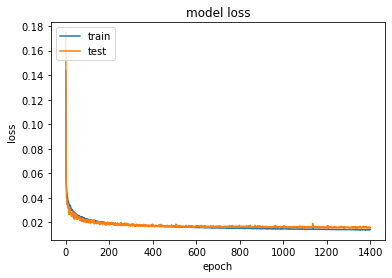

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('training_curves.png')
plt.show()

# Testing

In [20]:
y_predict = model.predict(x_test, batch_size=batch_size) 
y_predict_in_val = model.predict(x_val, batch_size=batch_size)
y_predict_in_train = model.predict(x_train, batch_size=batch_size)


Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_622774 in device /job:localhost/replica:0/task

Revert the Representation from normalize to lat-long coordinates

In [21]:
y_predict = scaler_y.inverse_transform(y_predict)
y_predict_in_train = scaler_y.inverse_transform(y_predict_in_train)
y_predict_in_val = scaler_y.inverse_transform(y_predict_in_val)
y_train = scaler_y.inverse_transform(y_train)
y_val = scaler_y.inverse_transform(y_val)
y_test = scaler_y.inverse_transform(y_test)

Calculate Haversine Error

In [22]:
print("Train set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'mean')))
print("Train set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'median')))
print("Train set75th perc error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'percentile',75)))
print("Val set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'mean')))
print("Val set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'median')))
print("Val set 75th perc.  error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'percentile',75)))
print("Test set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'mean')))
print("Test set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'median')))
print("Test set  75th perc. error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'percentile',75)))


Train set mean error: 123.68
Train set median error: 47.09
Train set75th perc error: 127.74
Val set mean error: 163.68
Val set median error: 54.77
Val set 75th perc.  error: 187.36
Test set mean error: 162.23
Test set median error: 54.56
Test set  75th perc. error: 181.65


In [23]:
test_error_list = calculate_pairwise_error_list(y_predict,y_test)
p.DataFrame(test_error_list).to_csv(trial_name+".csv")
print("Experiment completed!!!")

Experiment completed!!!


In [24]:
# keras library import  for Saving and loading model and weights

from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open(trial_name+".json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(trial_name+".h5")